# Exp 05 - Geometry

Synthetic spectra are generated for similar conditions as the Saharan reference set, expect solar zenith angle and instrument viewing angle. For each fluorescence strength (0, 0.5, 1.0, 2.0, 4.0), 200 individual spectra are available. A total of 12 retrievals are conducted, based on combinations of spectral window and number of principal components:

1. 712-783nm (KNMI)
2. 712-758nm (H2O)
3. 734-783nm (O2-a)
4. 734-758nm (Joiner)

For PCA:

1. 8 PCA's (Joiner)
2. 20 PCA's (?)
3. 35 PCA's (KNMI)

The scenarios will be assessed on:
- RMSE 
- r (correlation)
- bias
- sigma (std. deviation)
- slope (linear regression)
- intercept (linear regression)

In [4]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import h5py
import gc
import math
import glob
import os
import sys
sys.path.insert(0, '/usr/people/botiabo/Fluor_retrieval')
import scipy.stats as stats
from sklearn.metrics import mean_squared_error as mse
import Retrieval.highsampling as high
from mpl_toolkits.basemap import Basemap

%matplotlib inline

# Set working directory
os.chdir('/usr/people/botiabo/00_AlbedoEffect_Aerosols/')

# Create function that returns the required variables from the level2 hdf
def read_hdf(fname):
    with h5py.File(fname) as outh:
        Fs  = outh['level2/param'][:,0] * 1e3      # Convert from W to mW
        res = outh['level2/res'][:]
        wl  = outh['level2/wavelength'][:]
    return([Fs],res,wl)

In [5]:
def plot_rectangle(bmap, lonmin,lonmax,latmin,latmax):
    xs = [lonmin,lonmax,lonmax,lonmin,lonmin]
    ys = [latmin,latmin,latmax,latmax,latmin]
    bmap.plot(xs, ys,latlon = True,color='red')

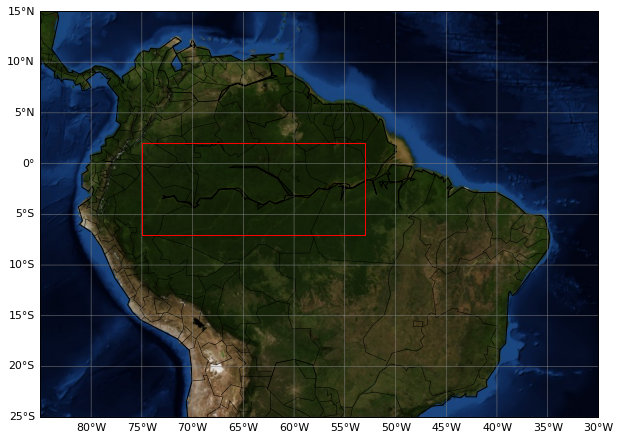

In [26]:
lllat        = -25
urlat        = 15
lllon        = -85
uprlon       = -30

#xx, yy   = np.meshgrid(np.arange(-180,180,0.5),np.arange(-90,90,0.5))
fig      = plt.figure(1,figsize=(10,10))
ax       = fig.add_subplot(111)
map      = Basemap(projection='cyl',llcrnrlat=lllat, urcrnrlat=urlat, llcrnrlon=lllon, urcrnrlon=uprlon)
map.drawcoastlines()
map.drawcountries()
map.drawstates()
map.bluemarble()
map.drawparallels(np.arange(-30,30,5),color='grey',linewidth=0.5,dashes=[1,0.0001],labels=[1,0,0,0],fontsize=11)
map.drawmeridians(np.arange(-80,0,5),color='grey',linewidth=0.5,dashes=[1,0.0001],labels=[0,0,0,1],fontsize=11)
#map.lsmask
plot_rectangle(map,-75,-53,-7,2)

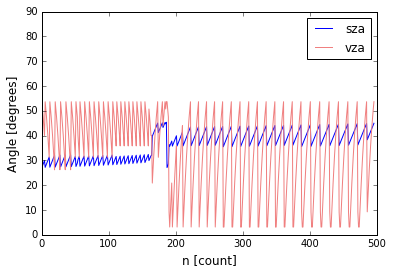

27.109243
45.378405
3.101602
53.685965


In [43]:
# Create combinations of viewing angles and solar angles representative of Russian boreal forest

# Open file(s)
with h5py.File('/usr/people/botiabo/botiabo/data_SIF/M02/gome2_level1b/2008/fluor_l1b_2008_09_21') as f:
    lat = f['level1b/lat'][:]
    lon = f['level1b/lon'][:]
    sza = f['level1b/SZA'][:]
    vza = f['level1b/VZA'][:]
    
# Create box
#min_lat = 55.
#max_lat = 65.
#min_lon = 31.
#max_lon = 131.

min_lat = -7.
max_lat = 2.
min_lon = -75.
max_lon = -53.

# Create mask for files in box
mask = np.all([lat >= min_lat, lat <= max_lat, lon >= min_lon, lon <= max_lon], axis=0)

# Combine
combined_sza_vza = np.rad2deg(np.array([sza[mask], vza[mask]]))

## Write
np.savetxt('/usr/people/botiabo/DISAMAR/scripts/combined_sza_vza_amazon.csv', combined_sza_vza, delimiter=',')

# Plot (for visual inspection)

plt.plot(combined_sza_vza[0,:], label='sza')
plt.plot(combined_sza_vza[1,:], color='lightcoral', label='vza')
plt.ylabel('Angle [degrees]', fontsize=12)
plt.xlabel('n [count]', fontsize=12)
plt.legend(loc=1)
plt.ylim(0,90)
plt.show()

print(np.min(combined_sza_vza[0,:]))
print(np.max(combined_sza_vza[0,:]))

print(np.min(combined_sza_vza[1,:]))
print(np.max(combined_sza_vza[1,:]))

#'''

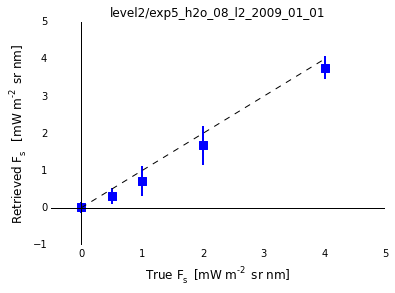

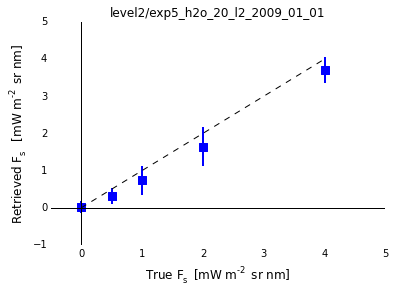

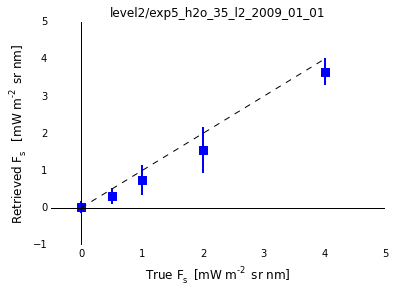

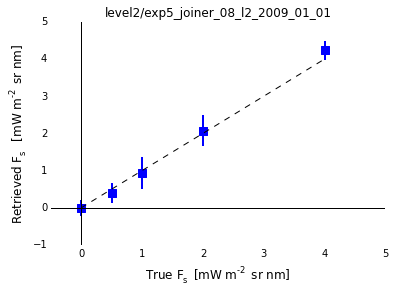

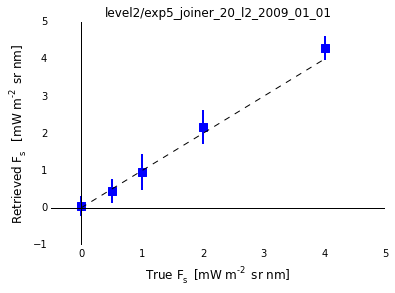

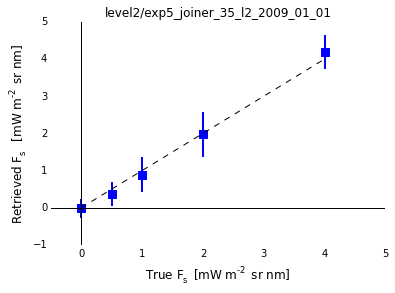

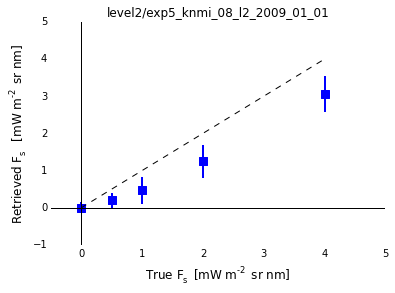

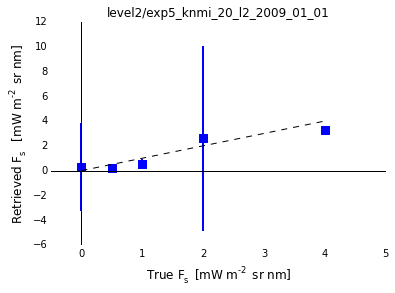

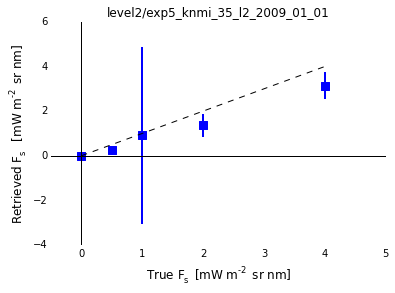

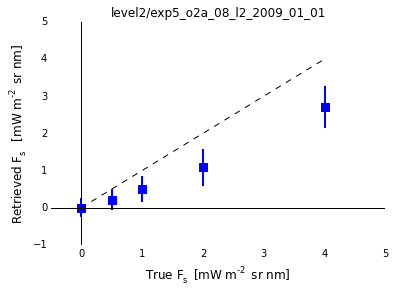

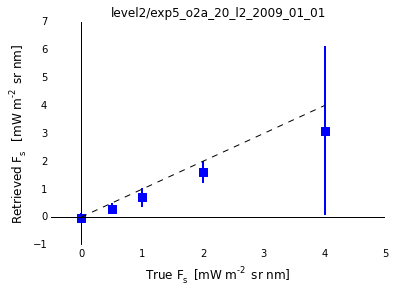

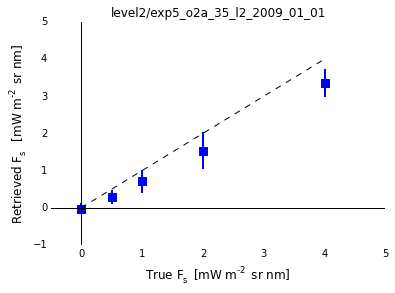

In [3]:
# Create plots similar to fig 12. in Joiner et al. (2013)
files = sorted(glob.glob('level2/*'))

# Create matrix to store statistics
storage_matrix = np.zeros((12,7))


for i in range(len(files)):
    d, res, wl = read_hdf(files[i])
    
    # Convert to column-based real Fs
    Fs = d[0].reshape((5,200)).transpose()
    
    # Create masks
    err_list = np.zeros(1000)
    for j in range(1000):
        err_list[j] = pd.Series(res[j,:]).autocorr(1)
    mask_acl = np.all([err_list > -0.50, err_list < 0.20], axis=0).reshape((5,200)).transpose()
    
    mask = mask_acl
    #mask = np.ones(mask_acl.shape, dtype=bool)
    #mask = np.all([mask_val == True, mask_acl == True], axis=0)
    
    
    ##### Derive statistics #############
    real_means  = np.array([0.0, 0.5, 1.0, 2.0, 4.0])
    stats_means = np.ones((200,5)) * real_means
    
    Fs_masked          = Fs.copy()
    Fs_masked[~mask]   = np.nan
    stats_means[~mask] = np.nan
    
    obs_means  = np.nanmean(Fs_masked, axis=0)
    obs_std    = np.nanstd(Fs_masked, axis=0)
    
    rmse        = np.sqrt(mse(Fs[mask],  stats_means[mask]))
    fit         = stats.linregress(real_means, obs_means)
    bias        = np.nanmean(Fs_masked) - np.nanmean(stats_means)
    sigma       = np.nanstd(Fs_masked - stats_means)
    
    # Store values
    storage_matrix[i,0] = rmse
    storage_matrix[i,1] = fit[2]
    storage_matrix[i,2] = bias
    storage_matrix[i,3] = sigma
    storage_matrix[i,4] = fit[0]
    storage_matrix[i,5] = fit[1]
    storage_matrix[i,6] = np.count_nonzero(~mask)
    
    
    ##### Create plots ##################
        
    # Create figure
    plt.figure()
    
    plt.axes(frameon = 0)
    plt.tick_params(axis='both', which='both', bottom='off', top='off', left='off', right='off')
    
    plt.scatter(real_means, obs_means, marker='s', color='b', s=50)
    plt.errorbar(real_means, obs_means, yerr=obs_std, fmt='none', color='b', capthick=0, lw=2)
    plt.plot(real_means, real_means, 'k--', label='1:1 line')
    
    plt.xlim(-0.5,5.0)
    #plt.ylim(-0.5,5.0)
    
    plt.xlabel('True $\mathregular{F_s}$ [$\mathregular{mW\ m^{-2}\ sr\ nm}$]', fontsize=12)
    plt.ylabel('Retrieved $\mathregular{F_s}$  [$\mathregular{mW\ m^{-2}\ sr\ nm}$]', fontsize=12)
    
    plt.title(str(files[i]))
    
    plt.axhline(0, color='k', ls='-')
    plt.axvline(0, color='k', ls='-')
    
    # plt.grid()
    
    if i == 3:
        plt.savefig('/usr/people/schaik/Documents/SIF/figures/exp1-5/exp5_joiner_08.pdf', bbox_inches='tight')
    if i == 8:
        plt.savefig('/usr/people/schaik/Documents/SIF/figures/exp1-5/exp5_knmi_35.pdf', bbox_inches='tight')
    
    plt.show()
    
# Write storage matrix to csv
data_frame = pd.DataFrame(storage_matrix)

data_frame.columns = ['RMSE', 'r', 'bias', 'sigma', 'slope', 'intercept', 'faulty']
data_frame['ID'] = np.arange(1,13,1)
data_frame['l 1'] = np.array([712]*3 + [734]*3 + [712]*3 + [734]*3)
data_frame['l 2'] = np.array([758]*3 + [758]*3 + [783]*3 + [783]*3)
data_frame['# PC'] = np.array([8,20,35]*4)
data_frame = data_frame[['ID', 'l 1', 'l 2', '# PC', 'RMSE', 'r', 
                         'bias', 'sigma', 'slope', 'intercept', 'faulty']]
data_frame = data_frame.round(2)

data_frame.to_csv('/usr/people/schaik/Documents/SIF/figures/exp1-5/exp5_data.csv' ,index=False)

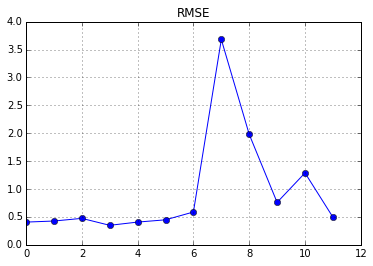

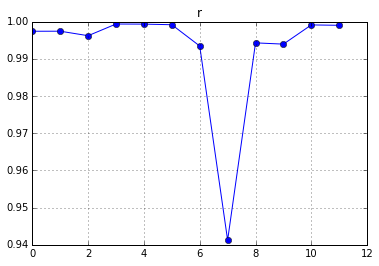

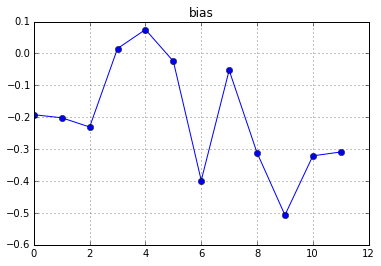

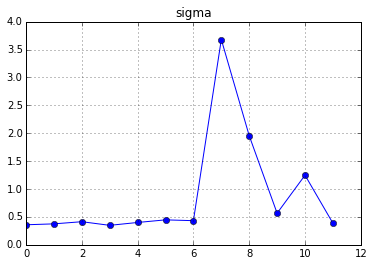

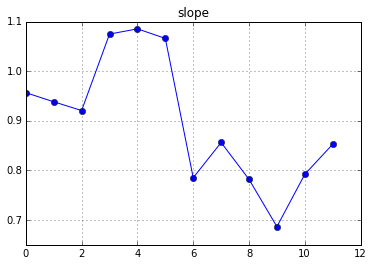

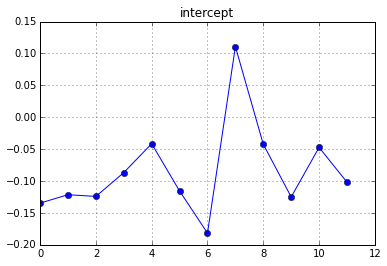

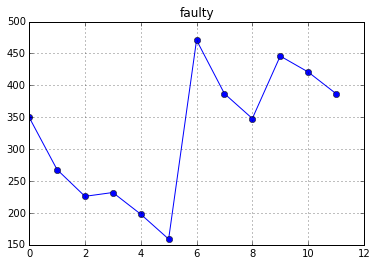

In [29]:
var_titles = ['RMSE', 'r', 'bias', 'sigma', 'slope', 'intercept', 'faulty']

for i in range(7):
    plt.plot(storage_matrix[:,i], 'o-')
    plt.title(var_titles[i])
    plt.grid()
    # plt.xlabel('Configuration', fontsize=12)
    plt.show()

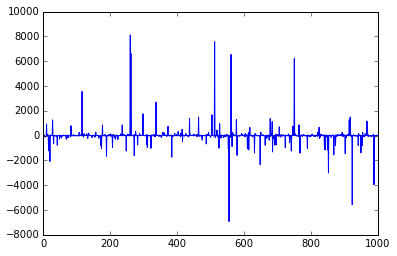

In [64]:
# Investigate surface proporties of fit
# Create function that returns the required variables from the level2 hdf
def read_hdf_soil(fname):
    with h5py.File(fname) as outh:
        Fs  = outh['level2/param'][:,:]      # Convert from W to mW
        res = outh['level2/res'][:]
        wl  = outh['level2/wavelength'][:]
    return(Fs,res,wl)

# Create plots similar to fig 12. in Joiner et al. (2013)
files = sorted(glob.glob('level2/exp5_joiner_08_l2_2009_01_01'))

for i in range(len(files)):
    d, res, wl = read_hdf_soil(files[i])
    
surf_prop = d[:,1:6]

plt.plot(surf_prop[:,1])
plt.show()

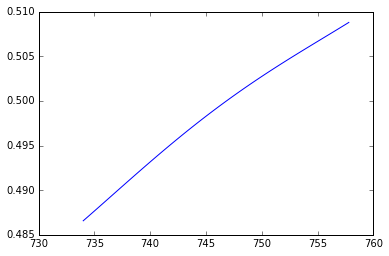

In [66]:
surf_prop = d[:,1:6]

nr = 3
ar = np.asarray([wl**i for i in range(4+1)])

surf_ref = -sum(surf_prop[nr,:][:,None] * ar)

plt.plot(wl, surf_ref)
#plt.ylim(0,np.max(surf_ref))

plt.show()

In [8]:
# Create functions
mu_f    = 737. 
sigma_f = 33.9

def gauss(x, mu_f, sigma_f):
    return np.exp(-(x-mu_f)**2/(2.*sigma_f**2))

# Get parameters
def read_hdf_redo(fname):
    with h5py.File(fname) as outh:
        Fs  = outh['level2/param'][:,:]      # Convert from W to mW
        res = outh['level2/res'][:]
        wl  = outh['level2/wavelength'][:]
        sza = outh['level2/SZA'][:]
        vza = outh['level2/VZA'][:]
    return(Fs,res,wl,sza,vza)

with h5py.File('/nobackup/users/schaik/Data/exp5_geometry/exp5_knmi_35/exp5_knmi_35_EOF_2009_01') as pc_file:
    PCs = pc_file['EOF'][:]

d, res, wl, sza, vza = read_hdf_redo('level2/exp5_knmi_35_l2_2009_01_01')
wlp = np.asarray([wl**i for i in range(4+1)])

refspec = high.convolve_refspec()[1]

theta = lambda x: (x - 3)*2*np.pi/365
solspec = lambda x: refspec(x)*((1+0.01671022*np.cos(theta(354)))/(1+0.01671022*np.cos(theta(354))))**2

fluor = np.pi*gauss(wl, mu_f, sigma_f)/solspec(wl)

nr = 878

mu = np.cos(vza[nr])
mu0 = np.cos(sza[nr])
mu1 = 1/mu0
mu2 = (1/mu)/((1/mu)+(1/mu0))

a = d[nr,0]
b = d[nr,1:6][:,None]
c = d[nr,6:][:,None]

T      = np.exp(-sum(c*PCs))
signal = sum(b*wlp)*T + a*mu1*fluor*T**mu2 + res[nr,:]

# Get real signal
with h5py.File('/usr/people/schaik/Documents/Code/output/DIS_exp5_geometry/DIS_exp5_geometry_OUT.hdf') as real_f:
    wl_real    = real_f['level1b/wavelength'][:]
    rad        = real_f['level1b/rad'][:]
    SMR        = real_f['level1b/SMR'][:]
    sza_1b     = real_f['level1b/SZA'][:]
    vza_1b     = real_f['level1b/VZA'][:]
    
mu  = np.cos(vza_1b)    
mu0 = np.cos(sza_1b)     
rad_real = (np.pi/mu0)*rad/SMR[0,:]

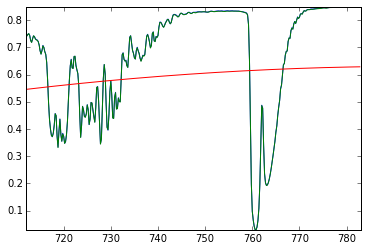

In [9]:
plt.plot(wl, signal)
plt.plot(wl_real[0,:], rad_real[nr,:])
plt.plot(wl, sum(b*wlp))
#plt.plot(wl, a*mu1*fluor)
plt.xlim(712,783)
#plt.xlim(734,758)
plt.ylim(np.min(signal), np.max(signal))
#plt.ylim(0,0.5)
plt.show()


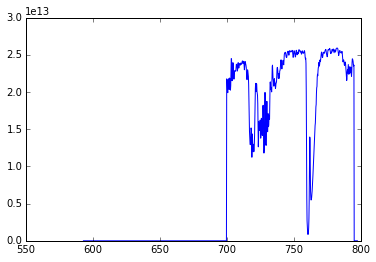

In [10]:
plt.plot(wl_real[0,:], rad[10,:])